In [1]:
import pandas as pd
from tqdm.notebook import tnrange, tqdm
import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from PIL import Image

In [14]:
torch.cuda.is_available()

False

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [25]:
def image_to_nparray(path):
    i = plt.imread(path)    
    return(np.array(i))

## A Custom class for this dataset:

In [26]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv_file_path, root_dir, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = pd.read_csv(csv_file_path, header= None)[1:]
    

        
    def __getitem__(self, idx): 
        smol_img_path = str(self.d.iloc[idx][3])
        class_name = str(self.d.iloc[idx][2])[-1] 
        full_img_path = self.root_dir + '/' + 'c'+ class_name + '/' + smol_img_path
        img_arr = image_to_nparray(full_img_path)

        if self.transform is not None:
            img_arr = self.transform(img_arr)
        
        return torch.tensor(int(class_name)), img_arr    
        
        

    def __len__(self):
        return (len(self.d))

## Custom class for adding Gaussian noise :

In [27]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [28]:
local_path='state-farm-distracted-driver-detection/imgs/train'
kaggle_path='../input/state-farm-distracted-driver-detection/imgs/train'

data = C_Dataset('balanced.csv', 
               local_path,
                transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((150,150), interpolation=2),
                                                transforms.RandomRotation(10),
                                                transforms.ToTensor(),
                                                #AddGaussianNoise(0., 0.05)
                                                ])
                )

print(len(data))

train_set, val_set = torch.utils.data.random_split(data, [len(data)-4000, 4000])

24890


## Plot samples from the train_loader :

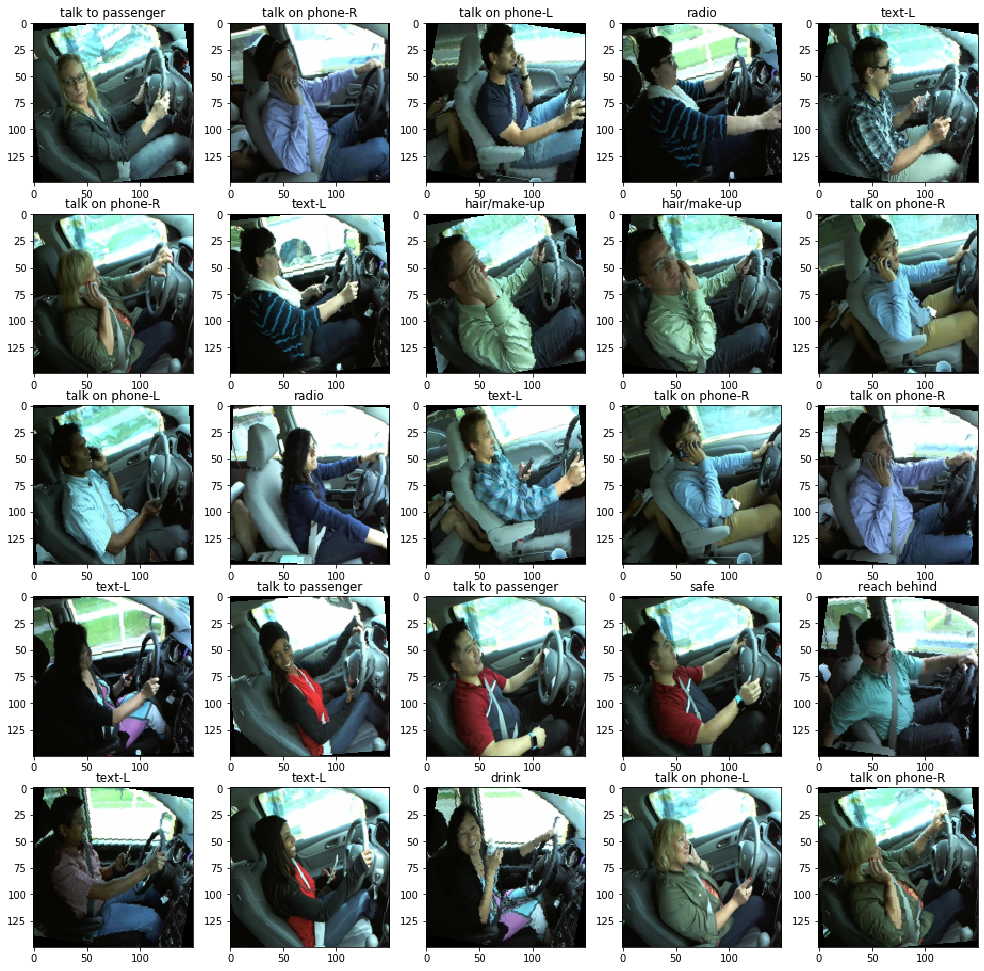

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [29]:
train_loader_1 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=10
    ,shuffle=True
)

class_list = ['safe', 'text-R', 'talk on phone-R', 'text-L', 'talk on phone-L', 'radio', 'drink'
, 'reach behind', 'hair/make-up', 'talk to passenger']
fig, axs = plt.subplots(5, 5, figsize=(17,17))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for labels,images in (train_loader_1):
            
            x=np.transpose(images[0], (1, 2, 0))  
            class_number = labels[0].item()
            im_label=class_list[class_number]
            axs[j,i].imshow(x, interpolation='none')
            axs[j,i].title.set_text(im_label)
            break
plt.show()

## The Model :

In [30]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

network = model_ft.to(device)

In [36]:
print(network)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
train_loader_2 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=128
    ,shuffle=True
    ,num_workers=8
)

val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=128, 
    shuffle=True,
    num_workers=8
)

loss_list=[]
acc_list=[]
val_loss_list=[]
val_acc_list=[]


optimizer = optim.Adam(network.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4)

## Training Loop :

In [ ]:
for epoch in tnrange(6):
    
    total_loss = 0
    total_correct = 0
    total_loss2 = 0
    total_correct2 = 0

    for batch in tqdm(train_loader_2): # Get Batch

        labels, images = batch
        images=images.to(device)
        labels=labels.to(device)

        preds = network(images)
        
        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() 
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
        
        
    with torch.no_grad():
        network.eval()
        for batch2 in (val_loader): # Get Batch

            labels2, images2 = batch2
            images2=images2.to(device)
            labels2=labels2.to(device)
            
            preds2 = network(images2) # Pass Batch
        
            loss2 = F.cross_entropy(preds2, labels2)
            
            total_loss2 += loss2.item()
            total_correct2 += get_num_correct(preds2, labels2)
            

    loss_list.append(total_loss/(len(train_set)))
    acc_list.append(total_correct/(len(train_set)))
    val_loss_list.append(total_loss2/(len(val_set)))
    val_acc_list.append(total_correct2/(len(val_set)))

In [18]:
def plot_metric(arg, frm):
    
    if (arg)=='loss':
        a,b = loss_list, val_loss_list
    elif (arg)=='accuracy':
        a,b=acc_list, val_acc_list
            
    plt.plot(a[frm:], label='Training ' + str(arg))
    plt.plot(b[frm:], label='Validation ' + str(arg))
    plt.xlabel(str(arg))
    plt.ylabel("Epochs")
    plt.grid()
    plt.legend()
    plt.show()

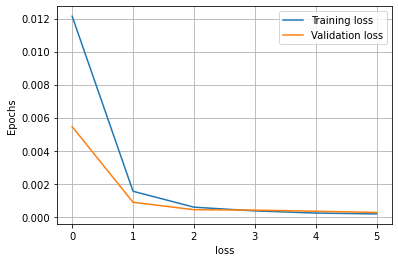

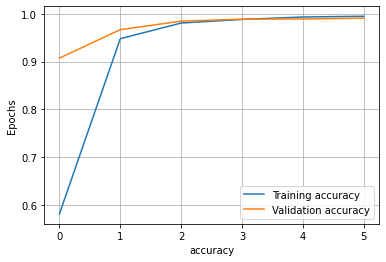

In [29]:
plot_metric('loss', 0)
plot_metric('accuracy', 0)

In [ ]:
torch.save(network.state_dict(), './model_res18_1.pt')

In [48]:
#load on GPU: network.load_state_dict(torch.load('./model_res18_1.pt')
network.load_state_dict(torch.load('./model_res18_1.pt', map_location={'cuda:0': 'cpu'}))

<All keys matched successfully>

In [50]:
local_test_csv_path='state-farm-distracted-driver-detection/sample_submission.csv'
kaggle_test_csv_path='../input/state-farm-distracted-driver-detection/sample_submission.csv'

df_test=pd.read_csv(local_test_csv_path)
df_test

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79722,img_99995.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79723,img_99996.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79724,img_99998.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [51]:
class test_Dataset(Dataset):
    """custom"""

    def __init__(self, csv_file_path, root_dir, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = pd.read_csv(csv_file_path, header= None)[1:]
    

        
    def __getitem__(self, idx): 
        smol_img_path = str(self.d.iloc[idx][0])
        full_img_path = self.root_dir + '/' + smol_img_path
        img_arr = image_to_nparray(full_img_path)

        if self.transform is not None:
            img_arr = self.transform(img_arr)
        
        return img_arr    
        
        

    def __len__(self):
        return (len(self.d))

In [56]:
local_test_imgs_path='state-farm-distracted-driver-detection/imgs/test'
kaggle_test_imgs_path='../input/state-farm-distracted-driver-detection/imgs/test'

test_data = test_Dataset(local_test_csv_path, 
                local_test_imgs_path,
                transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224), interpolation=2),
                                                transforms.ToTensor(),
                                                #AddGaussianNoise(0., 0.05)
                                                ])
                )

print(len(test_data))

79726


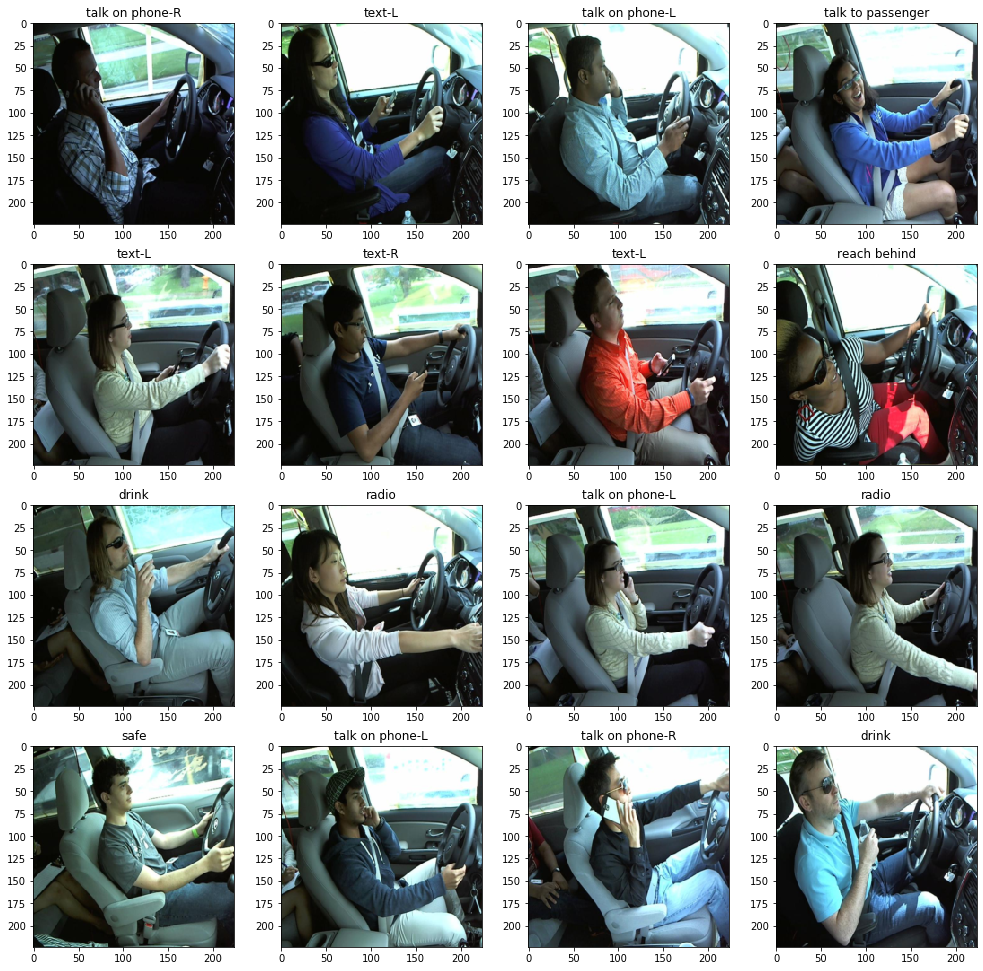

<Figure size 3600x3600 with 0 Axes>

In [60]:
test_loader = torch.utils.data.DataLoader(
     test_data
    ,batch_size=1
    ,shuffle=True
)

class_list = ['safe', 'text-R', 'talk on phone-R', 'text-L', 'talk on phone-L', 'radio', 'drink'
, 'reach behind', 'hair/make-up', 'talk to passenger']
fig, axs = plt.subplots(4, 4, figsize=(17,17))
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for images in (test_loader):
            
            x=np.transpose(images[0], (1, 2, 0))  
            axs[j,i].imshow(x, interpolation='none')
            
            with torch.no_grad():

                network.eval()
                images = images.to(device)
                lab=network(images[0].unsqueeze(0))
                lab = lab.cpu()
                max_index = np.argmax(lab[0]) 
                predicted_label = class_list[max_index]
            
            axs[j,i].title.set_text(predicted_label)
            break
plt.show()